In [1]:
import gym
import logging
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
import env
%load_ext autoreload
%matplotlib inline
%autoreload 2
import matplotlib
import matplotlib.pyplot as plt
from IPython import display

In [14]:
Q=np.eye(4)
Q[2,2]=100
Q[0,0]=1
Q*=0.1
R=0.1
state_track=np.array([1,0,0 * np.pi,0])
gamma=0.95

In [3]:
def Cost(Q,R,K,g,state_track,state_0=np.array([0.0, 0.0, 0 * np.pi, 0.0]),gamma=0.9,show=False):
    env = gym.make('CartPoleLQR-v0').env
    state = env.reset(Q,R,state_track,state_0,gamma)
    cost=0
    f_max=20
    if show:
        img = plt.imshow(env.render(mode='rgb_array'))
    while True:
        if show:
            img.set_data(env.render(mode='rgb_array')) # just update the data
            display.display(plt.gcf())
            display.clear_output(wait=True)
        u=K.dot(np.array(state))+g
        #print(u)
        #print(cost)
        u=np.asscalar(u)
        u=np.clip(u,-f_max,f_max)
        state, reward, done, _ = env.step([u])
        cost+=-reward
        if done:
            break
    return cost

In [4]:
def sample_u(d):
    ret=np.zeros(d)
    for i in range(d):
        ret[i]=np.random.normal(0,1)
    ret/=np.linalg.norm(ret)
    return ret
# one point zeroth order estimater
def gr_1(A,B,Q,R,K,g,x_,x_0,gamma):#TODO
    r=0.01
    n,k=B.shape
    d=n*k+k
    u=sample_u(n*k+k)
    u_K=u[:n*k].reshape(n,k)
    u_g=u[-k:]
    
    cost=Cost(A,B,Q,R,K+r*u_K,g+r*u_g,x_,x_0)
    ret=d/r*cost
    return ret*u_K,ret*u_g
def gr_2(Q,R,K,g,x_,x_0=np.array([0.0, 0.0, 0* np.pi, 0.0]),gamma=0.9):
    r=0.01
    n=4
    k=1
    d=n*k+k
    u=sample_u(n*k+k)
    u_K=u[:n*k].reshape(k,n)
    u_g=u[-k:]
    #print(K,r*u_K)
    #print(g+r*u_g)
    cost1=Cost(Q,R,K+r*u_K,g+r*u_g,x_,x_0,gamma=gamma)
    cost2=Cost(Q,R,K-r*u_K,g-r*u_g,x_,x_0,gamma=gamma)
    ret=d/(2*r)*(cost1-cost2)
    
    return ret*u_K,ret*u_g
def sample_x0():
    return np.array([0,0,np.random.normal()* np.pi*0.1,0])

In [6]:
gr_2(Q,R,K,g,state_track,gamma=0.95)

C:\Users\zhong\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
C:\Users\zhong\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Environment '<class 'env.cartpole_LQR.CartPoleLQREnv'>' has deprecated methods '_step' and '_reset' rather than 'step' and 'reset'. Compatibility code invoked. Set _gym_disable_underscore_compat = True to disable this behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
C:\Users\zhong\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  app.launch_new_instance()


(array([[ 2.53828231, -0.55933962,  4.26498618, -4.29123898]]),
 array([[1.46740541]]))

array([[2.94281092]])

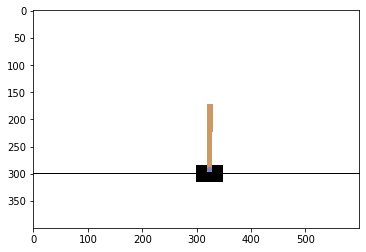

In [33]:
i=3
Cost(Q,R,K_global,local_gs[i],x_track[i],state_0=x_0[i],gamma=gamma,show=True)

In [34]:
local_gs

[array([[0.84847866]]),
 array([[0.76020679]]),
 array([[0.68747997]]),
 array([[0.60099554]])]

# Same target

In [81]:
from time import time
m=5
H=1
max_epoch=1500
gamma=0.95
costs=[]
for run in range(5):
    K=np.array([0.1, 0.1,-1,-1]).reshape(1,4)
    g=3
    local_gs=[g for i in range(m)]
    local_Ks=[K for i in range(m)]
    np.random.seed(0)
    
    
    x_track=[np.array([(-2+i)*0.5,0,0,0]) for i in range(m)]
    x_00=np.array([0,0,np.random.normal()* np.pi*0.05,0])
    
    
    x_0=[x_00 for i in range(m)]
    
    best_gs=[]
    
    
    K_global=K
    
    lr=0.01
    
    J_K_0=[Cost(Q,R,local_Ks[i],local_gs[i],x_track[i],state_0=x_0[i],gamma=gamma) for i in range(m)]
    for i in range(m):
        print(f"Agent{i}: {J_K_0[i]}")
    cost=[]
    
    np.random.seed(int(time()))
    for epoch in range(max_epoch):
        for i in range(m):
    
            
            for t in range(H):
                z_K,z_g=gr_2(Q,R,local_Ks[i],local_gs[i],x_=x_track[i],x_0=x_0[i],gamma=gamma)
                #print(z_K,z_g)
                local_Ks[i]=local_Ks[i]-lr*z_K
                local_gs[i]=local_gs[i]-lr*z_g/m
    
    
        #print(K_global)
        #print(local_gs[0])
        mean_cost=np.sum([Cost(Q,R,local_Ks[i],local_gs[i],x_track[i],state_0=x_0[i],gamma=gamma) for i in range(m)])/m
        if epoch%100==0:
            print(f"epoch:{epoch}, average cost:{mean_cost}")
        cost.append(mean_cost)
    costs.append(cost)

C:\Users\zhong\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  app.launch_new_instance()


Agent0: [[189.47110142]]
Agent1: [[187.59330725]]
Agent2: [[186.66551288]]
Agent3: [[186.68771832]]
Agent4: [[187.65992355]]
epoch:0, average cost:473.1050550091105
epoch:100, average cost:538.3476516204817
epoch:200, average cost:582.2350651558656
epoch:300, average cost:490.80994123335296
epoch:400, average cost:466.6524680073535
epoch:500, average cost:406.18531710274334
epoch:600, average cost:550.88371113379
epoch:700, average cost:532.4697040537678
epoch:800, average cost:538.8334564251861
epoch:900, average cost:514.175640521283
epoch:1000, average cost:540.2694182709441
epoch:1100, average cost:539.705652029855
epoch:1200, average cost:539.5930255170829
epoch:1300, average cost:539.5159234463764
epoch:1400, average cost:539.0378155035044
Agent0: [[189.47110142]]
Agent1: [[187.59330725]]
Agent2: [[186.66551288]]
Agent3: [[186.68771832]]
Agent4: [[187.65992355]]
epoch:0, average cost:759.2282620945438
epoch:100, average cost:168.82051124566942
epoch:200, average cost:88.691014657

In [94]:
cost_ind=[costs[1]]+costs[3:]

In [87]:
for i in range(5):
    print(len(costs[i]))

1500
1500
1500
1500
1500


In [95]:
cost_ind=np.stack(cost_ind)
mean_cost_ind=np.mean(cost_ind,axis=0)
std_cost_ind=np.std(cost_ind,axis=0)

In [99]:
cost_fed=np.load("fed_costs.npy")

In [101]:
cost_fed.shape
mean_cost_fed=np.mean(cost_fed,axis=0)
std_cost_fed=np.std(cost_fed,axis=0)

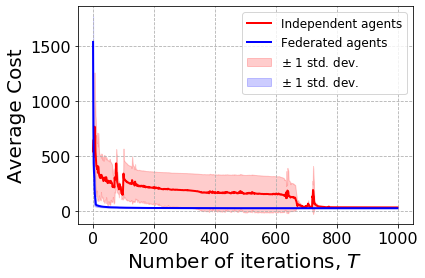

<Figure size 432x288 with 0 Axes>

In [108]:
rc('text', usetex=False)
plt.figure(figsize=(6,4))



plt.plot(np.arange(1000),mean_cost_ind[:1000],"-",label="Independent agents",linewidth=2,color="red")
tprs_upper1 = mean_cost_ind+std_cost_ind
tprs_lower1 = mean_cost_ind-std_cost_ind
plt.fill_between(np.arange(1000), tprs_lower1[:1000], tprs_upper1[:1000], color='red', alpha=.2,
                label=r'$\pm$ 1 std. dev.')
plt.plot(np.arange(1000),mean_cost_fed[:1000],"-",label="Federated agents",linewidth=2,color="blue")
tprs_upper1 = mean_cost_fed+std_cost_fed
tprs_lower1 = mean_cost_fed-std_cost_fed
plt.fill_between(np.arange(1000), tprs_lower1[:1000], tprs_upper1[:1000], color='blue', alpha=.2,
                label=r'$\pm$ 1 std. dev.')
#plt.xscale('log')
#plt.yscale('log')
#plt.xlim(0,1050)
plt.legend(loc=1,prop={'size':12})

plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16) 
plt.ylabel("Average Cost",fontsize=20)
plt.xlabel("Number of iterations, $T$",fontsize=20)
plt.grid(linestyle='--')
plt.show()
plt.savefig('learning_curve.eps', format='eps')

In [68]:
m=4
H=1
max_epoch=2000
gamma=0.95
#K=np.array([3.1623 ,  6.8378 , -67.8026 , -19.0559] ).reshape(1,4)
K=np.array([0.1, 0.1,-1,-1]).reshape(1,4)
g=3
local_gs=[g for i in range(m)]
local_Ks=[K for i in range(m)]
np.random.seed(0)
#x_track=[np.array([10,0,0,0]) for i in range(m)]
x_track=[np.array([1,0,0,0]) for i in range(m)]
x_00=np.array([0,0,np.random.normal()* np.pi*0.05,0])
#x_00=np.array([0,0,0,0])
x_0=[x_00 for i in range(m)]
best_gs=[]


K_global=K
#K_global=np.array([-3.7036208 ,  8.76492109, 17.30110446, 30.86955573])
lr=0.0005
J_K_0=[Cost(Q,R,K_global,local_gs[i],x_track[i],state_0=x_0[i],gamma=gamma) for i in range(m)]
for i in range(m):
    print(f"Agent{i}: {J_K_0[i]}")
cost1=[]
#np.random.seed(int(time()))
for epoch in range(max_epoch):
    local_Ks=[]
    for i in range(m):
        K_local=K_global
        
        for t in range(H):
            z_K,z_g=gr_2(Q,R,K_local,local_gs[i],x_=x_track[i],x_0=x_0[i],gamma=gamma)
            #print(z_K,z_g)
            K_local=K_local-lr*z_K
            local_gs[i]=local_gs[i]-lr*z_g/m
        local_Ks.append(np.array(K_local))
    #print(np.stack(local_Ks).shape)
    K_global=np.mean(np.stack(local_Ks),axis=0)
    #print(K_global)
    #print(local_gs[0])
    mean_cost=np.sum([Cost(Q,R,K_global,local_gs[i],x_track[i],state_0=x_0[i],gamma=gamma) for i in range(m)])/m
    if epoch%10==0:
        print(f"epoch:{epoch}, average cost:{mean_cost}")
    cost1.append(mean_cost)

C:\Users\zhong\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  app.launch_new_instance()


Agent0: [[187.65992355]]
epoch:0, average cost:186.6908032744311
epoch:10, average cost:206.40271376713946
epoch:20, average cost:73.89299031461488
epoch:30, average cost:162.33193928267036
epoch:40, average cost:171.4755289460693
epoch:50, average cost:162.43479782327262
epoch:60, average cost:178.56124944905767
epoch:70, average cost:91.26359233403133
epoch:80, average cost:152.14989230485713
epoch:90, average cost:191.00165737308157
epoch:100, average cost:50.50024879262808
epoch:110, average cost:118.53240196427205
epoch:120, average cost:55.04682419012989
epoch:130, average cost:147.01049035493762
epoch:140, average cost:151.05033072588134
epoch:150, average cost:72.52403083898125
epoch:160, average cost:220.05313560728402
epoch:170, average cost:127.0842357422963
epoch:180, average cost:73.69286043759557
epoch:190, average cost:126.73530044804333
epoch:200, average cost:38.44934780995146
epoch:210, average cost:40.1724133784308
epoch:220, average cost:59.44549489519709
epoch:230,

In [67]:
m=4
H=1
max_epoch=2000
gamma=0.95
#K=np.array([3.1623 ,  6.8378 , -67.8026 , -19.0559] ).reshape(1,4)
K=np.array([0.1, 0.1,-1,-1]).reshape(1,4)
g=3
local_gs=[g for i in range(m)]
np.random.seed(0)
#x_track=[np.array([10,0,0,0]) for i in range(m)]
x_track=[np.array([1,0,0,0]) for i in range(m)]
x_00=np.array([0,0,np.random.normal()* np.pi*0.05,0])
#x_00=np.array([0,0,0,0])
x_0=[x_00 for i in range(m)]
best_gs=[]


K_global=K
#K_global=np.array([-3.7036208 ,  8.76492109, 17.30110446, 30.86955573])
lr=0.1
J_K_0=[Cost(Q,R,K_global,local_gs[i],x_track[i],state_0=x_0[i],gamma=gamma) for i in range(m)]
for i in range(m):
    print(f"Agent{i}: {J_K_0[i]}")
cost=[]
#np.random.seed(int(time()))
for epoch in range(max_epoch):
    local_Ks=[]
    for i in range(m):
        K_local=K_global
        
        for t in range(H):
            z_K,z_g=gr_2(Q,R,K_local,local_gs[i],x_=x_track[i],x_0=x_0[i],gamma=gamma)
            #print(z_K,z_g)
            K_local=K_local-lr*z_K
            local_gs[i]=local_gs[i]-lr*z_g/m
        local_Ks.append(np.array(K_local))
    #print(np.stack(local_Ks).shape)
    K_global=np.mean(np.stack(local_Ks),axis=0)
    #print(K_global)
    #print(local_gs[0])
    mean_cost=np.sum([Cost(Q,R,K_global,local_gs[i],x_track[i],state_0=x_0[i],gamma=gamma) for i in range(m)])/m
    if epoch%10==0:
        print(f"epoch:{epoch}, average cost:{mean_cost}")
    cost.append(mean_cost)

C:\Users\zhong\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  app.launch_new_instance()


Agent0: [[187.65992355]]
Agent1: [[187.65992355]]
Agent2: [[187.65992355]]
Agent3: [[187.65992355]]
epoch:0, average cost:918.9156345273757
epoch:10, average cost:88.15610619735075
epoch:20, average cost:60.71471497253209
epoch:30, average cost:47.47783375288323
epoch:40, average cost:44.531815452424695
epoch:50, average cost:42.903379285148766
epoch:60, average cost:41.19326598369625
epoch:70, average cost:40.54648178572407
epoch:80, average cost:39.82116089880055
epoch:90, average cost:39.17111349402802
epoch:100, average cost:38.92171835351438
epoch:110, average cost:38.55719262377281
epoch:120, average cost:38.33210137030906
epoch:130, average cost:38.14129038763982
epoch:140, average cost:37.869882277001764
epoch:150, average cost:37.71505153611626
epoch:160, average cost:37.43630724858061
epoch:170, average cost:35.877074529130276
epoch:180, average cost:35.06099329148898
epoch:190, average cost:34.563291319278505
epoch:200, average cost:33.58507505659757
epoch:210, average cost:

In [64]:
cost_fed=cost1

In [69]:
cost_ind=cost1

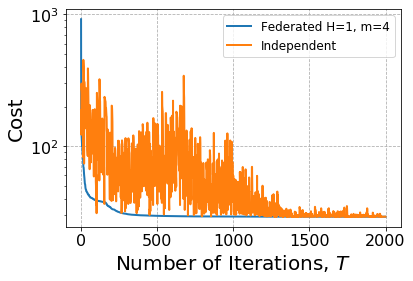

<Figure size 432x288 with 0 Axes>

In [74]:
from matplotlib import rc
rc('text', usetex=False)
plt.figure(figsize=(6,4))

plt.plot(np.arange(2000),cost_fed[:2000],"-",label="Federated H=1, m=4",linewidth=2)
plt.plot(np.arange(2000),cost_ind[:2000],"-",label="Independent",linewidth=2)



#plt.xscale('log')
plt.yscale('log')
#plt.xlim(0,1050)
plt.legend(loc=1,prop={'size':12})

plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16) 
plt.ylabel("Cost",fontsize=20)
plt.xlabel("Number of Iterations, $T$",fontsize=20)
plt.grid(linestyle='--')
plt.show()
plt.savefig('nolinear.eps', format='eps')

In [66]:
m=5
H=1
max_epoch=100000
gamma=0.99
#K=np.array([3.1623 ,  6.8378 , -67.8026 , -19.0559] ).reshape(1,4)
K=np.array([0.1, 0.1,-1,-1]).reshape(1,4)
g=0
local_gs=[np.ones(1)*3 for i in range(m)]
np.random.seed(0)
x_track=[np.array([-2+1*i,0,0,0]) for i in range(m)]
x_00=np.array([0,0,np.random.normal()* np.pi*0.1,0])
#x_00=np.array([0,0,0,0])
x_0=[x_00 for i in range(m)]
best_gs=[]


#K_global=K
K_global=np.array([-4.68299821, -3.28195466, 10.14700093, 18.32834617])
lr=0.0005
J_K_0=[Cost(Q,R,K,local_gs[i],x_track[i],state_0=x_0[i],gamma=gamma) for i in range(m)]
for i in range(m):
    print(f"Agent{i}: {J_K_0[i]}")
cost1=[]
#np.random.seed(int(time()))
for epoch in range(max_epoch):
    local_Ks=[]
    for i in range(m):
        K_local=K_global
        
        for t in range(H):
            z_K,z_g=gr_2(Q,R,K_local,local_gs[i],x_=x_track[i],x_0=x_0[i],gamma=gamma)
            #print(z_K,z_g)
            K_local=K_local-lr*z_K
            local_gs[i]=local_gs[i]-lr*z_g/m
        local_Ks.append(np.array(K_local))
    #print(np.stack(local_Ks).shape)
    K_global=np.mean(np.stack(local_Ks),axis=0)
    #print(K_global)
    #print(local_gs[0])
    mean_cost=np.sum([Cost(Q,R,K_global,local_gs[i],x_track[i],state_0=x_0[i],gamma=gamma) for i in range(m)])/m
    if epoch%100==0:
        print(f"epoch:{epoch}, average cost:{mean_cost}")
    cost1.append(mean_cost)

C:\Users\zhong\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  app.launch_new_instance()


Agent0: [[7629.77244987]]
Agent1: [[7633.4071573]]
Agent2: [[7654.18906718]]
Agent3: [[7692.11817949]]
Agent4: [[7747.19449424]]
epoch:0, average cost:21448.059821474824
epoch:100, average cost:386.7784692186756
epoch:200, average cost:329.18157405215396
epoch:300, average cost:312.5136638059992
epoch:400, average cost:305.5722258722964
epoch:500, average cost:301.6117183216791
epoch:600, average cost:299.0327129988624
epoch:700, average cost:296.71899171302704
epoch:800, average cost:294.9865559686293
epoch:900, average cost:293.4917447273924
epoch:1000, average cost:292.2468198216226
epoch:1100, average cost:291.38054813773795
epoch:1200, average cost:290.4557268694403
epoch:1300, average cost:289.7162620870672
epoch:1400, average cost:289.0174854206062
epoch:1500, average cost:288.3721518810252
epoch:1600, average cost:287.8145444273707
epoch:1700, average cost:287.31297439042464
epoch:1800, average cost:286.8899139288184
epoch:1900, average cost:286.4472192351046
epoch:2000, averag

KeyboardInterrupt: 

In [52]:
lr=0.0005
gamma=0.99
for epoch in range(max_epoch):
    local_Ks=[]
    for i in range(m):
        K_local=K_global
        
        for t in range(H):
            z_K,z_g=gr_2(Q,R,K_local,local_gs[i],x_=x_track[i],x_0=x_0[i],gamma=gamma)
            #print(z_K,z_g)
            K_local=K_local-lr*z_K
            local_gs[i]=local_gs[i]-lr*z_g/m
        local_Ks.append(np.array(K_local))
    #print(np.stack(local_Ks).shape)
    K_global=np.mean(np.stack(local_Ks),axis=0)
    #print(K_global)
    #print(local_gs[0])
    mean_cost=np.sum([Cost(Q,R,K_global,local_gs[i],x_track[i],state_0=x_0[i],gamma=gamma) for i in range(m)])/m
    if epoch%100==0:
        print(f"epoch:{epoch}, average cost:{mean_cost}")
    cost1.append(mean_cost)

C:\Users\zhong\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  app.launch_new_instance()


epoch:0, average cost:766641.3312304638
epoch:100, average cost:13687529.908560198


KeyboardInterrupt: 

In [ ]:
from matplotlib import rc
rc('text', usetex=False)
plt.figure(figsize=(6,4))

plt.plot(np.arange(10000),cost1[:10000],"-",label="Federated H=1",linewidth=2)




#plt.xscale('log')
#plt.yscale('log')
#plt.xlim(0,1050)
plt.legend(loc=1,prop={'size':12})

plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16) 
plt.ylabel("Cost",fontsize=20)
plt.xlabel("Number of Iterations, $T$",fontsize=20)
plt.grid(linestyle='--')
plt.show()
plt.savefig('nolinear.eps', format='eps')

In [269]:
env = gym.make('CartPoleLQR-v0').env
state = env.reset(Q,R,state_track,state_0,gamma)
cost=0
img = plt.imshow(env.render(mode='rgb_array'))
while True:
    #img.set_data(env.render(mode='rgb_array')) # just update the data
    #display.display(plt.gcf())
    #display.clear_output(wait=True)
    u=K.dot(np.array(state))+g

    #print(cost)
    state, reward, done, _ = env.step([1])
    cost+=-reward
    if done:
        break

NameError: name 'state_0' is not defined

In [21]:
K_global# good

array([[-4.68299821, -3.28195466, 10.14700093, 18.32834617]])

In [52]:
K_global

array([[-3.7036208 ,  8.76492109, 17.30110446, 30.86955573]])

In [54]:
g_global

array([[3.223331]])